# Adil HTML Model Creation

In [ ]:
!pip install --upgrade google-cloud-storage

Requirement already up-to-date: google-cloud-storage in /usr/local/lib/python3.7/dist-packages (1.38.0)


## Upload CSV File to Colab Runtime

In [ ]:
!wget --no-check-certificate \
      https://storage.googleapis.com/adil-dataset/adil-dataset-v2.csv \
      -O ./data.csv

--2021-05-29 10:58:08--  https://storage.googleapis.com/adil-dataset/adil-dataset-v2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5161194 (4.9M) [application/octet-stream]
Saving to: ‘./data.csv’

./data.csv          100%[===================>]   4.92M  --.-KB/s    in 0.03s   

2021-05-29 10:58:08 (145 MB/s) - ‘./data.csv’ saved [5161194/5161194]



## Importing Libraries


In [ ]:
import tensorflow as tf
import pandas as pd
import sklearn
import csv
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

print(tf.__version__)

2.5.0


## Prepocessing


In [ ]:
vocab_size = 10000
embedding_dim = 32

TEST_SIZE = 0.2

BUFFER_SIZE = 1000
BATCH_SIZE = 32

contents = []
labels = []

### Open Dataset CSV

In [ ]:
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[2])
        contents.append(row[1])

### Split Training and Validation Data

In [ ]:
train_contents, validation_contents, train_labels, validation_labels = train_test_split(contents, labels, test_size=TEST_SIZE)

In [ ]:
validation_contents, test_contents, validation_labels, test_labels = train_test_split(validation_contents, validation_labels, test_size=0.3)

### Tokenization

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index

print(label_index)

{'body': 1, 'subtitle': 2, 'title': 3, 'section': 4}


### Pad Sequences

In [ ]:
train_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

print(len(train_label_seq))
print(train_label_seq.shape)

print(len(validation_label_seq))
print(validation_label_seq.shape)

print(len(test_label_seq))
print(test_label_seq.shape)

35308
(35308, 1)
6179
(6179, 1)
2649
(2649, 1)


### Convert to TF Datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_contents, train_label_seq)) \
                .batch(BATCH_SIZE, drop_remainder=True).shuffle(BUFFER_SIZE) \
                .prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_contents, validation_label_seq)).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_contents, test_label_seq)).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((32,), (32, 1)), types: (tf.string, tf.int64)>

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:10])
  print()
  print('labels: ', label.numpy()[:10])

texts:  [b'TATA CARA PEMANFAATAN KAYU DAN/ATAU PENGENAAN PENERIMAAN NEGARA BUKAN PAJAK ATAS PEMANFAATAN HASIL HUTAN KAYU PADA KEGIATAN USAHA PERKEBUNAN YANG MEMPEROLEH KEPUTUSAN PELEPASAN KAWASAN HUTAN '
 b'Peraturan Lembaga Pemerintah Non Kementerian 25 2016'
 b'Pasal 25 \n Cukup jelas'
 b'PEDOMAN BANTUAN STIMULAN PENINGKATAN KUALITAS \nPERUMAHAN KUMUH DAN PERMUKIMAN KUMUH'
 b'Ketentuan lebih lanjut mengenai siaran iklan diatur dengan Peraturan\nPemerintah.'
 b'Peraturan Menteri 10 2016'
 b'b. bahwa untuk melaksanakan bantuan stimulan \nperumahan swadaya yang lebih akuntabel, tepat \nsasaran dan tepat waktu, perlu lebih memperjelas \nkriteria subjek dan objek, menyederhanakan prosedur, \nlebih memperjelas tanggung jawab para pelaksana \nserta meningkatkan pengawasan dan pengendalian;'
 b'(1) Sebelum melaksanakan pemungutan suara, KPPS:' b'Pasal 3.'
 b'Peraturan Lembaga Pemerintah Non Kementerian 23 2017']

labels:  [[2]
 [3]
 [4]
 [2]
 [1]
 [3]
 [1]
 [1]
 [4]
 [3]]


### Create the encoder

In [ ]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
print(len(vocab))
print(vocab[:10])

10000
['' '[UNK]' 'dan' 'peraturan' 'pasal' 'yang' 'menteri' 'dalam'
 'pemerintah' '1']


## Neural Network Creation



### Network Layers

In [ ]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(len(encoder.get_vocabulary()), embedding_dim, mask_zero=True),
    keras.layers.Conv1D(32, 1, activation='relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

### Loss Function and Optimizer

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### Train the model

In [ ]:
EPOCHS = 15
steps_epoch = len(train_contents) // BATCH_SIZE
validation_step = len(validation_contents) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=validation_dataset,
                    validation_steps=validation_step, 
                    steps_per_epoch=steps_epoch)

Epoch 1/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.5375 - accuracy: 0.8014 - val_loss: 0.1694 - val_accuracy: 0.9425
Epoch 2/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.1321 - accuracy: 0.9602 - val_loss: 0.1376 - val_accuracy: 0.9530
Epoch 3/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0925 - accuracy: 0.9695 - val_loss: 0.1234 - val_accuracy: 0.9542
Epoch 4/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0730 - accuracy: 0.9771 - val_loss: 0.1129 - val_accuracy: 0.9605
Epoch 5/15
1103/1103 [==============================] - 5s 5ms/step - loss: 0.0626 - accuracy: 0.9792 - val_loss: 0.1180 - val_accuracy: 0.9587
Epoch 6/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0538 - accuracy: 0.9827 - val_loss: 0.1240 - val_accuracy: 0.9587
Epoch 7/15
1103/1103 [==============================] - 5s 4ms/step - loss: 0.0466 - accuracy: 0.9846 - val_loss: 0.1313 - val_accuracy:

### Evaluate Model

In [ ]:
test_step = len(test_contents) // BATCH_SIZE

model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=test_step)

82/82 [==============================] - 0s 1ms/step - loss: 0.1829 - accuracy: 0.9619


[0.18292713165283203, 0.9618902206420898]

### Visualize Learning History

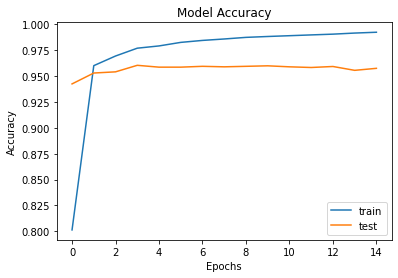

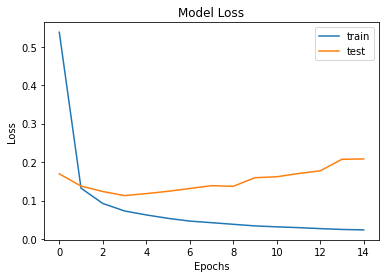

In [ ]:
def visualize_history():
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

visualize_history()

### Predict Model

In [ ]:
word = ("Undang-Undang 10 2012")

model.predict(np.array([word]))

array([[0., 0., 0., 1., 0.]], dtype=float32)

## Save model to GCP Bucket

In [ ]:
!mkdir -p saved_model

### Save model to Local Storage

In [ ]:
model.save('saved_model/adil_model')

INFO:tensorflow:Assets written to: saved_model/adil_model/assets


In [ ]:
!zip -r saved_model/adil_model.zip saved_model/adil_model

  adding: saved_model/adil_model/ (stored 0%)
  adding: saved_model/adil_model/saved_model.pb (deflated 89%)
  adding: saved_model/adil_model/variables/ (stored 0%)
  adding: saved_model/adil_model/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: saved_model/adil_model/variables/variables.index (deflated 60%)
  adding: saved_model/adil_model/keras_metadata.pb (deflated 87%)
  adding: saved_model/adil_model/assets/ (stored 0%)


### Upload Service Account from GCP

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  service_account = fn
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=service_account, length=len(uploaded[fn])))

Saving adil-gcp-13783a2acc15.json to adil-gcp-13783a2acc15.json
User uploaded file "adil-gcp-13783a2acc15.json" with length 2293 bytes


In [ ]:
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = service_account

In [ ]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

adil-gcp-13783a2acc15.json




```
# Ini diformat sebagai kode
```

### Upload Model to Bucket

In [ ]:
from google.cloud import storage

def upload_model(bucket_name, source_name, destination_name):
  storage_client = storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(destination_name)

  blob.upload_from_filename(source_name)
  print("File {} uploaded to Bucket: {}, with filename: {}".format(source_name, 
                                                                   bucket_name, 
                                                                   destination_name))

In [ ]:
upload_model("adil-model", "saved_model/adil_model.zip", "adil_model_v2.zip")

File saved_model/adil_model.zip uploaded to Bucket: adil-model, with filename: adil_model_v2.zip
